In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 수정
import os
print('os.getcwd():',os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/[M3]Data_Preprocessing/Data')
print('os.getcwd():',os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
os.getcwd(): /content
os.getcwd(): /content/drive/MyDrive/Colab Notebooks/[M3]Data_Preprocessing/Data


택시 요금 데이터에 관해 Data Cleaning을 실시해보았다.

# 데이터 탐색
---
택시 요금 관련 데이터를 불러온다. 이 때 taxi변수에 데이터를 담아주고, 대략적인 정보를 확인해본다.

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 택시 요금 데이터 불러오기
taxi = pd.read_csv('trip.csv')

In [4]:
# 데이터 확인
taxi.info()
display(taxi.head(3))
display(taxi.tail(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22701 entries, 0 to 22700
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_name         22701 non-null  object 
 1   tpep_pickup_datetime   22701 non-null  object 
 2   tpep_dropoff_datetime  22701 non-null  object 
 3   payment_method         22701 non-null  object 
 4   passenger_count        22701 non-null  int64  
 5   trip_distance          22701 non-null  float64
 6   fare_amount            22698 non-null  float64
 7   tip_amount             22701 non-null  float64
 8   tolls_amount           22701 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.6+ MB


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,Debit Card,1,1.00,6.5,1.45,0.0


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
22698,Drew Graves,09/04/2017 2:54:14 PM,09/04/2017 2:58:22 PM,Debit Card,1,0.42,4.5,0.00,0.0
22699,Jonathan Copeland,07/15/2017 12:56:30 PM,07/15/2017 1:08:26 PM,Debit Card,1,2.36,10.5,1.70,0.0
22700,Benjamin Miller,03/02/2017 1:02:49 PM,03/02/2017 1:16:09 PM,Cash,1,2.10,11.0,2.35,0.0


## 데이터에 관한 정보
- 택시요금 데이터는 총 22701개의 내역으로 구성되어 있다.
- 컬럼의 개수는 총 9개이며 각각의 컬럼은 아래와 같은 의미를 지닌다.

```
- passenger_name: 승객이름
- tpep_pickup_datetime: 승차시간
- tpep_dropff_datetime: 하차시간
- payment_method: 지불방법
- passenger_count: 승객 수
- trip_distance: 이동거리
- fare_amount: 이용요금
- tip_amount: 팁
- toll_amount: 톨게이트 요금
*tpep는 이 데이터가 뉴욕시 택시 위원회에서 수집된 데이터임을
명확히 하기 위해 접두사로 사용
```

- 수치형 변수: passenger_count, trip_distance, fare_amount, tip_amount, toll_amount
- 문자형 변수: passenger_name, tpep_pickup_datetime, tpep_dropff_datetime, payment_method
- fare_amount에 결측치가 존재하는 것으로 확인된다.

- 원본데이터를 유지하기 위해 Data Cleaning에 사용할 데이터를 taxi_df로 복사해준다.

In [5]:
# taxi데이터 복사
taxi_df = taxi.copy()
taxi_df.head()

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,Debit Card,1,1.00,6.5,1.45,0.0
3,Anthony Ray,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,Cash,1,3.70,20.5,6.39,0.0
4,Brianna Johnson,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,Debit Card,1,4.37,16.5,0.00,0.0


# 날짜 데이터 변환 및 컬럼 생성
---
 tpep_pickup_datetime, tpep_dropff_datetime는 날짜시간을 나타내는 데이터지만, 문자형 변수로 되어있다. 이후 데이터 분석의 편리성을 위해 datetime으로 변환하고 하차시간과 승차시간의 차이를 나타내는 이용시간(duration)컬럼과 이를 분으로 변환한 minutes 컬럼을 함께 만들어준다.

**날짜 데이터 변환**
: 승차시간과 하차시간의 데이터타입을 datetime으로 변환


In [6]:
#  tpep_pickup_datetime, tpep_dropff_datetime를 datetime으로 변환

from datetime import datetime

taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'])
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'])

In [7]:
taxi_df.info()
taxi_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22701 entries, 0 to 22700
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   passenger_name         22701 non-null  object        
 1   tpep_pickup_datetime   22701 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  22701 non-null  datetime64[ns]
 3   payment_method         22701 non-null  object        
 4   passenger_count        22701 non-null  int64         
 5   trip_distance          22701 non-null  float64       
 6   fare_amount            22698 non-null  float64       
 7   tip_amount             22701 non-null  float64       
 8   tolls_amount           22701 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 1.6+ MB


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,2017-03-25 08:55:43,2017-03-25 09:09:47,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,2017-04-11 14:53:28,2017-04-11 15:19:58,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,2017-12-15 07:26:56,2017-12-15 07:34:08,Debit Card,1,1.00,6.5,1.45,0.0
3,Anthony Ray,2017-05-07 13:17:59,2017-05-07 13:48:14,Cash,1,3.70,20.5,6.39,0.0
4,Brianna Johnson,2017-04-15 23:32:20,2017-04-15 23:49:03,Debit Card,1,4.37,16.5,0.00,0.0


- 승차시간과 하차시간의 데이터 타입이 datetime64으로 변경되었음을 확인할 수 있다.

**이용시간(duration) 컬럼 생성** : 하차시간과 승차시간의 차이를 나타내는 이용시간(duration)컬럼을 만들어준다.

In [8]:
# duration 컬럼 생성
taxi_df['duration'] = taxi_df['tpep_dropoff_datetime'] - taxi_df['tpep_pickup_datetime']

**이용시간을 분으로 변환**한 minutes컬럼을 생성해준다.

In [9]:
#  minutes 컬럼 생성
taxi_df['minutes'] = taxi_df['duration'].dt.total_seconds()/60

In [10]:
# duration, minutes 컬럼 확인
taxi_df.info()
taxi_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22701 entries, 0 to 22700
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   passenger_name         22701 non-null  object         
 1   tpep_pickup_datetime   22701 non-null  datetime64[ns] 
 2   tpep_dropoff_datetime  22701 non-null  datetime64[ns] 
 3   payment_method         22701 non-null  object         
 4   passenger_count        22701 non-null  int64          
 5   trip_distance          22701 non-null  float64        
 6   fare_amount            22698 non-null  float64        
 7   tip_amount             22701 non-null  float64        
 8   tolls_amount           22701 non-null  float64        
 9   duration               22701 non-null  timedelta64[ns]
 10  minutes                22701 non-null  float64        
dtypes: datetime64[ns](2), float64(5), int64(1), object(2), timedelta64[ns](1)
memory usage: 1.9+ MB


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
0,Pamela Duffy,2017-03-25 08:55:43,2017-03-25 09:09:47,Debit Card,6,3.34,13.0,2.76,0.0,0 days 00:14:04,14.066667
1,Michelle Foster,2017-04-11 14:53:28,2017-04-11 15:19:58,Debit Card,1,1.80,16.0,4.00,0.0,0 days 00:26:30,26.500000
2,Tina Combs,2017-12-15 07:26:56,2017-12-15 07:34:08,Debit Card,1,1.00,6.5,1.45,0.0,0 days 00:07:12,7.200000


- duration컬럼이 timedelta형식으로 생성되었고, minutes 컬럼이 이를 분으로 변환했음을 확인할 수 있다.

# 결측치 판단 및 처리
---
전체 컬럼의 결측치의 유무와 비율을 확인해본다.

In [11]:
# 결측치 유무 확인
taxi_df.isna().sum()

,0
passenger_name,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
payment_method,0
passenger_count,0
trip_distance,0
fare_amount,3
tip_amount,0
tolls_amount,0
duration,0


In [12]:
# 결측치 비율
taxi_df.isna().mean()

,0
passenger_name,0.000000
tpep_pickup_datetime,0.000000
tpep_dropoff_datetime,0.000000
payment_method,0.000000
passenger_count,0.000000
trip_distance,0.000000
fare_amount,0.000132
tip_amount,0.000000
tolls_amount,0.000000
duration,0.000000


- fare_amount인 이용요금 데이터에 결측치가 3개 존재하나, 이는 전체 데이터의 0.01%정도로 적은 비율을 차지한다.


이용요금이 결측치인 데이터를 살펴본다.

In [13]:
# fare_amount가 결측치인 데이터
taxi_df[taxi_df['fare_amount'].isna()]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
52,Benjamin Johnson,2017-04-04 16:22:03,2017-04-04 16:35:30,Cash,1,2.20,NaN,0.0,0.00,0 days 00:13:27,13.450000
189,Maria Ibarra,2017-08-21 12:40:25,2017-08-21 13:12:31,Debit Card,3,15.20,NaN,5.0,0.00,0 days 00:32:06,32.100000
244,Tina Avila,2017-08-09 08:32:09,2017-08-09 09:31:11,Cash,1,15.89,NaN,10.0,5.76,0 days 00:59:02,59.033333


- 위 데이터에서 승객들은 실제로 택시를 이용했으나, 이용요금이 기록되지 않은걸로 확인된다.
- 3개의 데이터를 삭제해도 데이터 특성에 거의 영향을 주지 않을 것이므로 삭제한다.


In [14]:
# fare_amount가 결측치인 데이터 삭제
print('결측치 삭제 전 데이터의 차원: ', taxi_df.shape)
taxi_df = taxi_df.dropna()
print('결측치 삭제 후 데이터의 차원: ', taxi_df.shape)

결측치 삭제 전 데이터의 차원:  (22701, 11)
결측치 삭제 후 데이터의 차원:  (22698, 11)


In [15]:
# 결측치 삭제 후 결측치 유무 확인
taxi_df.isna().sum()

,0
passenger_name,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
payment_method,0
passenger_count,0
trip_distance,0
fare_amount,0
tip_amount,0
tolls_amount,0
duration,0


# 이상치 판단 및 처리
---
수치형 변수와 문자형 변수를 각각 살펴본다.


## 수치형 변수의 이상치 확인
---
수치형 변수의 기술통계량을 살펴보고 변수 하나씩 자세히 살펴본다.

In [16]:
# 수치형 변수 기술통계량
taxi_df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
count,22698,22698,22698.000000,22698.000000,22698.000000,22698.000000,22698.000000,22698,22698.000000
mean,2017-06-29 07:26:40.725746688,2017-06-29 07:43:41.432901632,1.643581,2.912318,13.024009,1.835327,0.312302,0 days 00:17:00.707154815,17.011786
min,2017-01-01 00:08:25,2017-01-01 00:17:20,0.000000,0.000000,-120.000000,0.000000,0.000000,-1 days +23:43:01,-16.983333
25%,2017-03-30 02:35:36.750000128,2017-03-30 02:45:08.500000,1.000000,0.990000,6.500000,0.000000,0.000000,0 days 00:06:39,6.650000
50%,2017-06-23 12:31:13.500000,2017-06-23 12:53:38,1.000000,1.610000,9.500000,1.350000,0.000000,0 days 00:11:10.500000,11.175000
75%,2017-10-02 10:43:06,2017-10-02 11:07:42.500000,2.000000,3.060000,14.500000,2.450000,0.000000,0 days 00:18:23,18.383333
max,2017-12-31 23:45:30,2017-12-31 23:49:24,36.000000,33.960000,999.990000,200.000000,19.100000,0 days 23:59:33,1439.550000
std,NaN,NaN,1.304983,3.651335,13.240074,2.800093,1.398775,0 days 01:01:59.832077059,61.997201


- 승차시간과 하차시간을 나타내는 tpep_pickup_datetime,	tpep_dropoff_datetime컬럼은 따로 보지 않고 다른 컬럼의 이상치를 볼 때 참고한다.
- 시간관련 컬럼은 duration보다 연산하기 용이한 minutes를 사용하고 duration 참고하는 정도로 살펴보려고 한다.

먼저 passenger_count,	trip_distance,	fare_amount,	tip_amount,	tolls_amount, minutes을 하나씩 살펴보며 이상치를 확인하고 마지막에 각 수치형 변수의 pairplot을 그려 다시 확인해본다.

## 승객 수(passenger_count) 컬럼 살펴보기

In [17]:
# 승객 수(passenger_count) 기술통계량 확인
taxi_df['passenger_count'].describe()

,passenger_count
count,22698.000000
mean,1.643581
std,1.304983
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,36.000000


** 이상치 확인해보기**
1. 승객 수의 최솟값이 0이다.
2. 승객 수의 최댓값이 36이다.

In [18]:
# passenger_count의 수를 내림차순 정렬
taxi_df.passenger_count.value_counts().sort_index()

,count
passenger_count,
0,33
1,16117
2,3305
3,952
4,455
5,1143
6,692
36,1


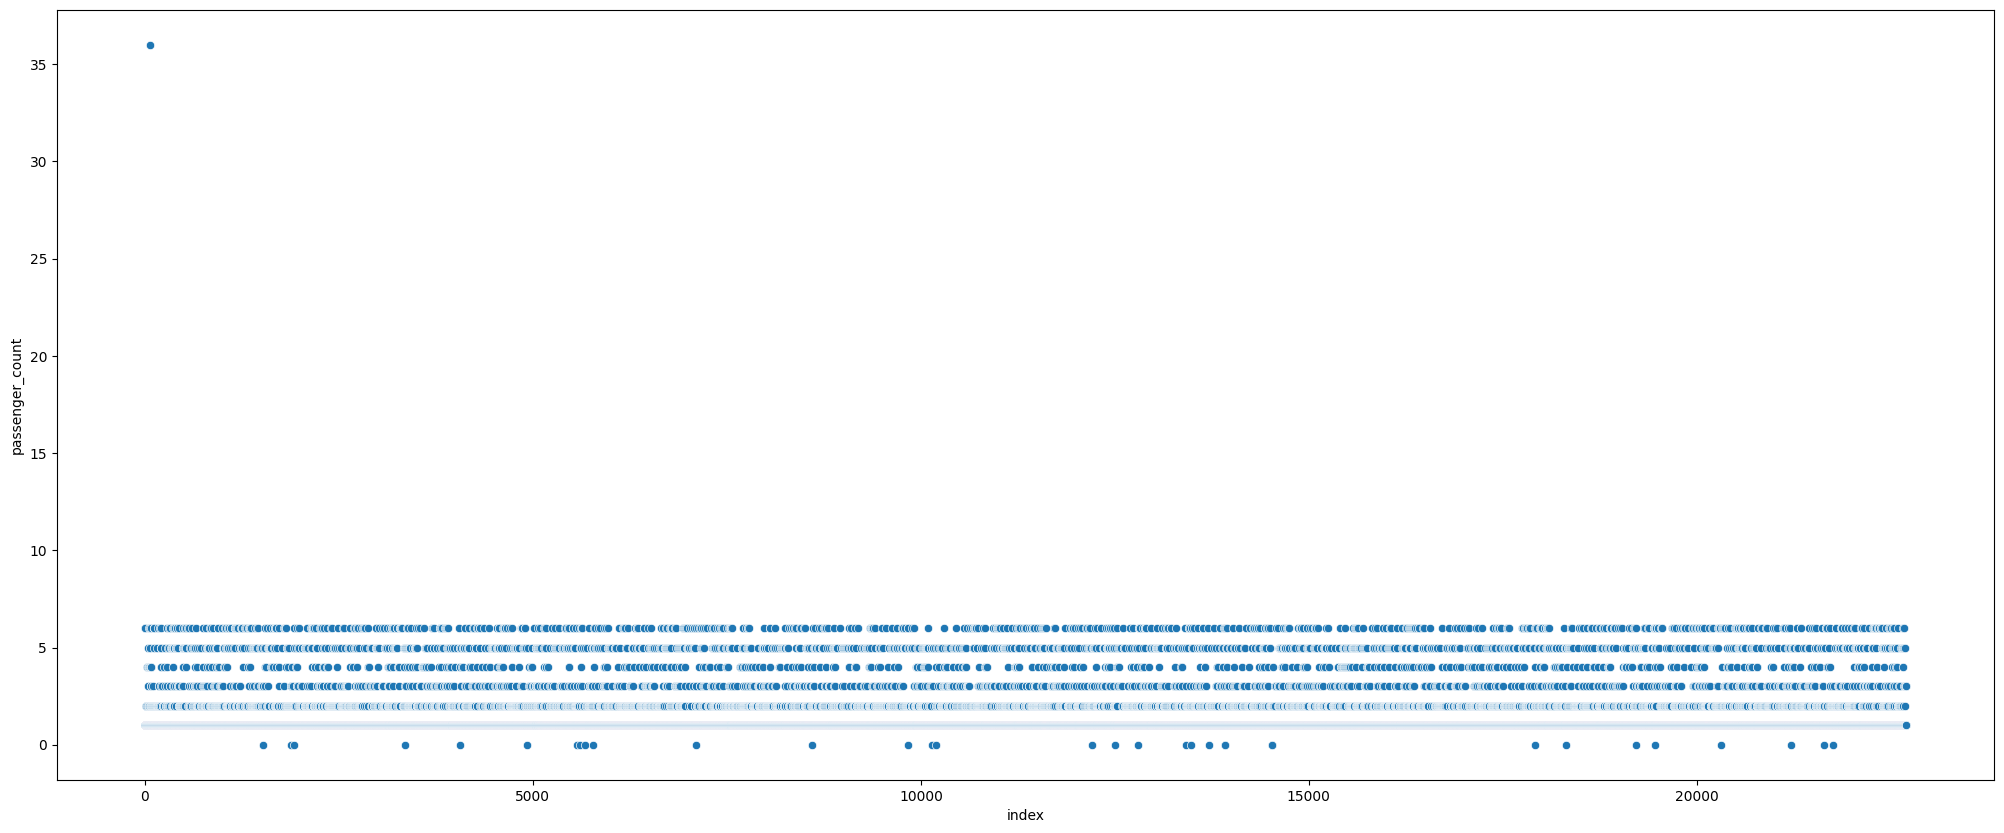

In [19]:
# passenger_count을 시각화
plt.figure(figsize = (25,10))
sns.scatterplot(x=taxi_df.index, y=taxi_df['passenger_count'])
plt.xlabel('index')
plt.ylabel('passenger_count')
plt.show()

- 승객 수가 0명인 데이터는 33개이다.
- 승객 수가 36명인 데이터는 1개이다.
- 승객 수가 5,6명인 경우도 많다고 판단되나, 각각 1143, 692개의 데이터가 집계되었으므로 대형 택시라고 간주한다.

승객 수가 36명인 데이터는 잘못 입력된 걸로 판단해서 삭제해준다.

In [20]:
# passenger_count = 36인 데이터 삭제
print(f'passenger_count = 36인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['passenger_count'] != 36]
print(f'passenger_count = 36인 데이터 삭제 후: {taxi_df.shape}')

passenger_count = 36인 데이터 삭제 전: (22698, 11)
passenger_count = 36인 데이터 삭제 후: (22697, 11)


승객 수가 0명인 데이터를 살펴보자.

In [21]:
# passenger_count = 0인 데이터
taxi_df[taxi_df['passenger_count'] == 0]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
1518,Sophia Hernandez,2017-11-14 15:45:23,2017-11-14 16:26:38,Debit Card,0,8.8,33.0,5.55,5.76,0 days 00:41:15,41.250000
1876,Tommy Weaver,2017-12-03 12:05:52,2017-12-03 12:13:51,Cash,0,1.1,7.0,0.00,0.00,0 days 00:07:59,7.983333
1927,Melissa Thompson,2017-09-09 03:44:45,2017-09-09 03:49:19,Cash,0,0.8,5.0,0.00,0.00,0 days 00:04:34,4.566667
3354,Lisa Wilson,2017-12-18 22:44:57,2017-12-18 23:00:24,Cash,0,2.7,12.5,2.75,0.00,0 days 00:15:27,15.450000
4062,Benjamin Anderson,2017-11-27 13:08:01,2017-11-27 13:17:55,Debit Card,0,1.7,9.0,1.95,0.00,0 days 00:09:54,9.900000
4921,Austin Gutierrez,2017-12-16 14:59:17,2017-12-16 15:21:59,Debit Card,0,3.1,15.5,4.05,0.00,0 days 00:22:42,22.700000
5565,Charles Stewart,2017-09-04 17:40:00,2017-09-04 17:51:52,Cash,0,1.3,9.0,1.95,0.00,0 days 00:11:52,11.866667
5605,Kristina Smith,2017-12-17 12:18:49,2017-12-17 12:40:45,Cash,0,4.2,18.0,3.75,0.00,0 days 00:21:56,21.933333
5670,Susan Cook,2017-12-16 19:50:12,2017-12-16 20:00:30,Cash,0,1.0,8.0,1.50,0.00,0 days 00:10:18,10.300000
5769,Rebecca Curry,2017-10-04 15:17:52,2017-10-04 15:56:26,Cash,0,10.4,34.0,8.10,5.76,0 days 00:38:34,38.566667


- 승객 수가 0인 데이터를 보았을 때, 이동거리, 이용요금이 있는 것으로 보아 이용시간이 0인 경우를 제외하고 실제로 이용한 내역임을 알 수있다. 승객 수가 제대로 입력이 안 된 것으로 보인다.

승객 수에서 0을 제외한 데이터와 다른 수치형 변수들의 상관관계를 보면 아래와 같다.

In [22]:
# 승객 수에서 0을 제외한 데이터와 다른 수치형 변수들의 상관관계
taxi_df[taxi_df['passenger_count'] != 0].corr(numeric_only = True)

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,minutes
passenger_count,1.000000,0.016356,0.010651,-0.009694,0.009740,0.016805
trip_distance,0.016356,1.000000,0.756938,0.501780,0.622749,0.153471
fare_amount,0.010651,0.756938,1.000000,0.679136,0.514018,0.128391
tip_amount,-0.009694,0.501780,0.679136,1.000000,0.421887,0.072440
tolls_amount,0.009740,0.622749,0.514018,0.421887,1.000000,0.084336
minutes,0.016805,0.153471,0.128391,0.072440,0.084336,1.000000


- passenger_count와의 상관계수 값이 모두 낮게 나온다. 따라서 다른 변수에 영향을 받지 않는 것으로 보여 승객 수가 0인 데이터를 삭제해준다.

In [23]:
# passenger_count = 0인 데이터 삭제
print(f'passenger_count = 0인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['passenger_count'] != 0]
print(f'passenger_count = 0인 데이터 삭제 후: {taxi_df.shape}')

passenger_count = 0인 데이터 삭제 전: (22697, 11)
passenger_count = 0인 데이터 삭제 후: (22664, 11)


## 이용요금(fare_amount) 살펴보기

In [24]:
# 이용요금(fare_amount) 기술통계량
taxi_df['fare_amount'].describe()

,fare_amount
count,22664.000000
mean,13.021985
std,13.240195
min,-120.000000
25%,6.500000
50%,9.500000
75%,14.500000
max,999.990000


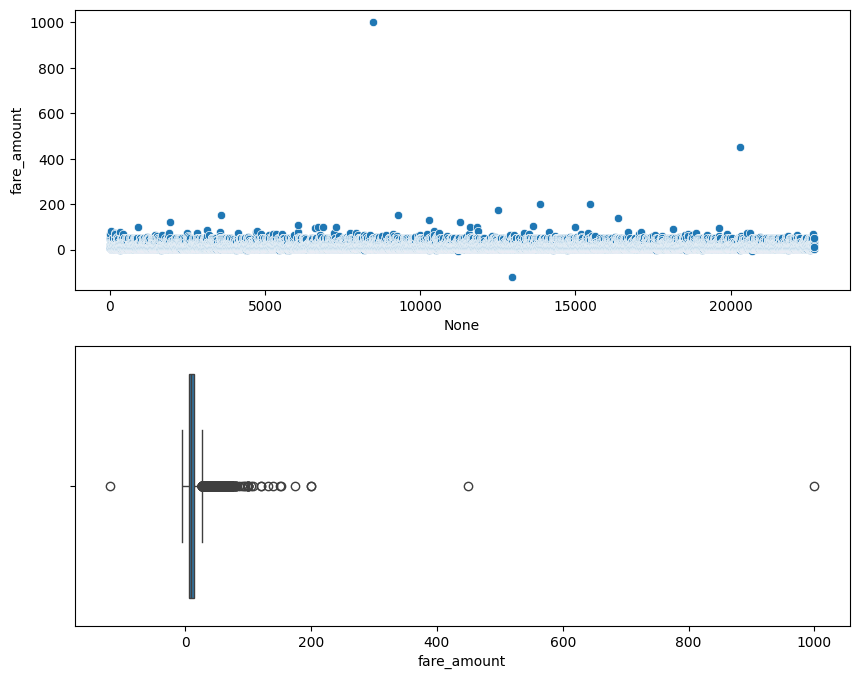

In [25]:
# 이용요금에 대해 시각화
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.scatterplot(x = taxi_df.index, y = taxi_df['fare_amount'], ax = axes[0])
sns.boxplot(x = taxi_df['fare_amount'],ax = axes[1])
plt.show()

**이상치 확인해보기**
1. 이용요금의 최솟값이 -120이다(음수값이다).
2. 이용요금이 마이너스값을 가진 변수들이 있는가?
3. 이용요금이 0인 데이터가 있는지 확인
4. 이용요금에서 마이너스값을 제외하고 가장 큰 두 값(400이상)이 그래프에서 이상치로 의심된다.

### 이용요금이 음수 값을 가지는 데이터
---
이용요금이 음수 값을 가지는 또 다른 데이터가 존재하는지 확인해본다. 만약 존재하는 경우, 결제취소 후 재결제를 한 고객일 수 있으니 비슷한 시간대에 같은 고객이 재결제를 한 내역이 있는지도 살펴본다.

In [26]:
# 이용요금이 음수 값을 가지는 데이터 확인
print('이용요금이 음수 값을 가지는 데이터 개수: ', len(taxi_df[taxi_df['fare_amount'] < 0]))
taxi_df[taxi_df['fare_amount'] < 0]

이용요금이 음수 값을 가지는 데이터 개수:  14


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
316,Tiffany Johnson,2017-12-13 02:02:39,2017-12-13 02:03:08,Cash,6,0.12,-2.5,0.0,0.0,0 days 00:00:29,0.483333
1648,Debbie Holmes,2017-07-05 11:02:23,2017-07-05 11:03:00,Credit Card,1,0.04,-2.5,0.0,0.0,0 days 00:00:37,0.616667
4425,Bobby Wilson,2017-11-16 20:13:30,2017-11-16 20:14:50,Cash,2,0.06,-3.0,0.0,0.0,0 days 00:01:20,1.333333
5450,Alejandro Williams,2017-04-06 12:50:26,2017-04-06 12:52:39,Debit Card,1,0.25,-3.5,0.0,0.0,0 days 00:02:13,2.216667
5760,Samuel Cooper,2017-01-03 20:15:23,2017-01-03 20:15:39,Debit Card,1,0.02,-2.5,0.0,0.0,0 days 00:00:16,0.266667
8206,Stephanie Summers,2017-10-28 20:39:36,2017-10-28 20:41:59,Credit Card,1,0.41,-3.5,0.0,0.0,0 days 00:02:23,2.383333
10283,Donna Larson,2017-06-05 17:34:25,2017-06-05 17:36:29,Credit Card,2,0.00,-2.5,0.0,0.0,0 days 00:02:04,2.066667
11206,Austin Fields,2017-07-09 07:20:59,2017-07-09 07:23:50,Debit Card,1,0.64,-4.5,0.0,0.0,0 days 00:02:51,2.850000
12946,Patrick Herring,2017-04-08 00:00:16,2017-04-08 23:15:57,Cash,1,0.17,-120.0,0.0,0.0,0 days 23:15:41,1395.683333
14716,Stefanie Warner,2017-12-24 22:37:58,2017-12-24 22:41:08,Debit Card,5,0.40,-4.0,0.0,0.0,0 days 00:03:10,3.166667


In [27]:
## 이용요금이 마이너스값을 가진 고객의 다른 기록추출 ##

# 이용요금이 마이너스인 고객 목록
minus_fare_name = taxi_df.loc[taxi_df['fare_amount'] < 0, 'passenger_name'].to_numpy()  # 연산을 위해 array로 추출

# 이용요금이 마이너스인 고객의 모든 거래 내역
print("이용요금이 마이너스인 고객의 모든 거래 건수: ", len(taxi_df[taxi_df['passenger_name'].isin(minus_fare_name)]))
taxi_df[taxi_df['passenger_name'].isin(minus_fare_name)]

이용요금이 마이너스인 고객의 모든 거래 건수:  16


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
316,Tiffany Johnson,2017-12-13 02:02:39,2017-12-13 02:03:08,Cash,6,0.12,-2.5,0.0,0.0,0 days 00:00:29,0.483333
688,Samuel Cooper,2017-06-21 22:05:17,2017-06-21 22:13:26,Cash,2,1.92,8.5,1.0,0.0,0 days 00:08:09,8.150000
1648,Debbie Holmes,2017-07-05 11:02:23,2017-07-05 11:03:00,Credit Card,1,0.04,-2.5,0.0,0.0,0 days 00:00:37,0.616667
4425,Bobby Wilson,2017-11-16 20:13:30,2017-11-16 20:14:50,Cash,2,0.06,-3.0,0.0,0.0,0 days 00:01:20,1.333333
5450,Alejandro Williams,2017-04-06 12:50:26,2017-04-06 12:52:39,Debit Card,1,0.25,-3.5,0.0,0.0,0 days 00:02:13,2.216667
5760,Samuel Cooper,2017-01-03 20:15:23,2017-01-03 20:15:39,Debit Card,1,0.02,-2.5,0.0,0.0,0 days 00:00:16,0.266667
8206,Stephanie Summers,2017-10-28 20:39:36,2017-10-28 20:41:59,Credit Card,1,0.41,-3.5,0.0,0.0,0 days 00:02:23,2.383333
10283,Donna Larson,2017-06-05 17:34:25,2017-06-05 17:36:29,Credit Card,2,0.00,-2.5,0.0,0.0,0 days 00:02:04,2.066667
10926,Tiffany Johnson,2017-11-08 17:58:27,2017-11-08 18:03:38,Cash,1,0.80,5.5,0.0,0.0,0 days 00:05:11,5.183333
11206,Austin Fields,2017-07-09 07:20:59,2017-07-09 07:23:50,Debit Card,1,0.64,-4.5,0.0,0.0,0 days 00:02:51,2.850000


In [28]:
# 요금이 마이너스 값인 고객 중 2번 이상 이용한 고객내역
taxi_df[taxi_df['passenger_name'].isin(['Tiffany Johnson','Samuel Cooper'])]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
316,Tiffany Johnson,2017-12-13 02:02:39,2017-12-13 02:03:08,Cash,6,0.12,-2.5,0.0,0.0,0 days 00:00:29,0.483333
688,Samuel Cooper,2017-06-21 22:05:17,2017-06-21 22:13:26,Cash,2,1.92,8.5,1.0,0.0,0 days 00:08:09,8.150000
5760,Samuel Cooper,2017-01-03 20:15:23,2017-01-03 20:15:39,Debit Card,1,0.02,-2.5,0.0,0.0,0 days 00:00:16,0.266667
10926,Tiffany Johnson,2017-11-08 17:58:27,2017-11-08 18:03:38,Cash,1,0.80,5.5,0.0,0.0,0 days 00:05:11,5.183333


- 이용요금이 마이너스값을 가진 고객들은 총 14명이지만, 2명의 고객만 또 다른 이용내역이 있었고, 그 이용내역 마저도 날짜와 시간이 많이 떨어져 있고 이용거리와 이용금액에도 차이가 있는걸로 보아, 재결제를 위한 결제취소 내역은 아닌걸 알 수 있다.
- 마이너스값에서 부호만 제거하여 데이터를 수정하는 방법을 생각할 수 있지만, 처음에 그래프에서 확인한 이용요금이 -120인 승객의 이동거리를 보았을 때 0.17로 매우 짧은 거리였다. 데이터의 신뢰도가 떨어질 수 있어 마이너스값을 가진 이용요금 데이터는 삭제해준다.

In [29]:
# fare_amount < 0 데이터 삭제
print(f'fare_amount < 0인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[~(taxi_df['fare_amount'] < 0)]
print(f'fare_amount < 0인 데이터 삭제 후: {taxi_df.shape}')

fare_amount < 0인 데이터 삭제 전: (22664, 11)
fare_amount < 0인 데이터 삭제 후: (22650, 11)


### 이용요금이 0인 데이터


In [30]:
# 이용요금이 0인 데이터 확인
taxi_df[taxi_df['fare_amount'] == 0]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
4404,Mrs. Tiffany Brown DDS,2017-12-20 16:06:53,2017-12-20 16:47:50,Cash,1,7.06,0.0,0.0,0.0,0 days 00:40:57,40.950000
5724,William Holland,2017-06-12 12:08:55,2017-06-12 12:08:57,Debit Card,1,0.00,0.0,0.0,0.0,0 days 00:00:02,0.033333
10508,Travis Vega,2017-03-30 03:14:26,2017-03-30 03:14:28,Debit Card,1,0.00,0.0,0.0,0.0,0 days 00:00:02,0.033333
19069,Glenn Garrett,2017-07-10 14:40:09,2017-07-10 14:40:59,Cash,1,0.10,0.0,0.0,0.0,0 days 00:00:50,0.833333
21844,Reginald Baker,2017-04-18 16:55:29,2017-04-18 18:29:44,Cash,2,20.40,0.0,0.0,12.5,0 days 01:34:15,94.250000
22568,Christine Edwards,2017-03-07 02:24:47,2017-03-07 02:24:50,Credit Card,1,0.00,0.0,0.0,0.0,0 days 00:00:03,0.050000


- 이동거리가 0 또는 0.1이면서 이용요금이 0인 데이터는 이용시간도 1분이 안됨을 알 수있다. 예약 후 취소한 이력이 아닐까 싶다. 삭제해준다.
- 이동거리가 존재하는 나머지 2개의 데이터는 실제 이용내역으로 보인다. 해당 이동거리의 90~110%사이에 해당하는 데이터들의 평균 이용요금으로 대체해준다.

In [31]:
# fare_amount = 0 이고 trip_distance = 0 또는 0.1인 데이터 삭제
zero_fare_con = (taxi_df['fare_amount'] == 0) & ((taxi_df['trip_distance'] == 0) | (taxi_df['trip_distance'] == 0.1))

print(f'fare_amount = 0, 0.1 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[~zero_fare_con]
print(f'fare_amount = 0, 0.1 데이터 삭제 후: {taxi_df.shape}')

fare_amount = 0, 0.1 데이터 삭제 전: (22650, 11)
fare_amount = 0, 0.1 데이터 삭제 후: (22646, 11)


In [32]:
# fare_amount = 0인 2개의 데이터 - index = 4404, 21844
# 해당 이동거리의 90~110%사이에 데이터들의 평균값으로 대체

# index = 4404 데이터
distance_4404 = taxi_df.loc[4404, 'trip_distance']

taxi_df.loc[4404, 'fare_amount'] = taxi_df.loc[(taxi_df['trip_distance'] > distance_4404*0.9) & (taxi_df['trip_distance'] < distance_4404*1.1), 'fare_amount'].mean().round(2)


# index = 21844 데이터
distance_21844 = taxi_df.loc[21844, 'trip_distance']

taxi_df.loc[21844, 'fare_amount'] = taxi_df.loc[(taxi_df['trip_distance'] > distance_21844*0.9) & (taxi_df['trip_distance'] < distance_21844*1.1), 'fare_amount'].mean().round(2)

taxi_df.loc[[4404, 21844]]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
4404,Mrs. Tiffany Brown DDS,2017-12-20 16:06:53,2017-12-20 16:47:50,Cash,1,7.06,25.02,0.0,0.0,0 days 00:40:57,40.95
21844,Reginald Baker,2017-04-18 16:55:29,2017-04-18 18:29:44,Cash,2,20.40,53.24,0.0,12.5,0 days 01:34:15,94.25


- 두 데이터의 fare_amount값이 대체되었음을 확인할 수 있다.

### 이용요금이 400을 넘는 데이터


In [33]:
# 이용요금이 400을 넘는 데이터 확인
taxi_df[taxi_df['fare_amount'] > 400]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
8478,Alexis Hanson,2017-02-06 05:50:10,2017-02-06 05:51:08,Credit Card,1,2.6,999.99,200.0,0.0,0 days 00:00:58,0.966667
20314,Nicholas Thomas,2017-12-19 09:40:46,2017-12-19 09:40:55,Cash,2,0.0,450.00,0.0,0.0,0 days 00:00:09,0.150000


- 두 데이터의 이동거리는 2.6, 0.0으로 짧거나 없으며 이용시간도 1분이 채 안된다. 택시를 이용했다고 볼 수 없으므로 삭제해준다.

In [34]:
# 이용요금이 400을 넘는 데이터 삭제
print(f'fare_amount > 400 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['fare_amount'] < 400]
print(f'fare_amount > 400 데이터 삭제 후: {taxi_df.shape}')

fare_amount > 400 데이터 삭제 전: (22646, 11)
fare_amount > 400 데이터 삭제 후: (22644, 11)


## 이동시간(duration, minutes) 살펴보기


In [35]:
# minutes 기술통계량
taxi_df.minutes.describe()

,minutes
count,22644.000000
mean,16.969002
std,61.388319
min,-16.983333
25%,6.666667
50%,11.183333
75%,18.383333
max,1439.550000


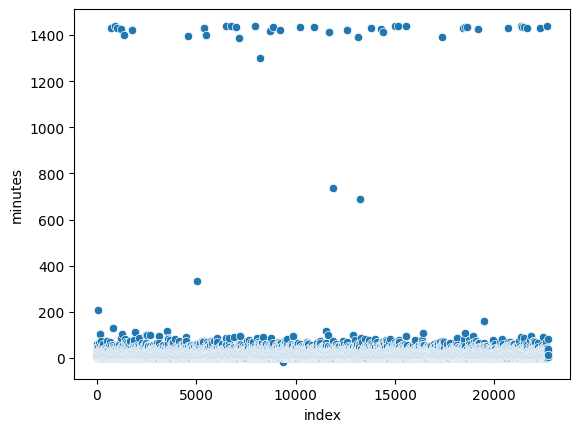

In [36]:
# minutes 컬럼 시각화
sns.scatterplot(x = taxi_df.index, y = taxi_df['minutes'])
plt.xlabel('index')
plt.show()

**이상치 확인해보기**
1. 이동시간의 최댓값이 -16.98이다. 이 값을 포함해서 이동시간이 마이너스 값을 가진 데이터를 확인해본다.
2. 이전 데이터에서 이동시간이 1분 미만의 데이터들이 있었다. 이동시간이 1분 미만은 택시를 이용했다고 보기 어려우므로, 데이터를 확인하고 처리해준다.
2. 이동시간의 최댓값이 약 1440분이며 이는 24시간, 즉 하루에 해당한다. 그래프에서도 이와 비슷한 시간대에 데이터들이 눈에 띈다.
3. 2에서 말한 데이터 이외에 250분 이상의 이동거리를 가진 데이터들도 확인해본다.


### 이동시간이 마이너스 값을 가지는 데이터

In [37]:
# minutes <  0 인 데이터 확인
taxi_df[taxi_df['minutes'] < 0]

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
9358,Donna Summers,2017-11-05 01:23:08,2017-11-05 01:06:09,Cash,1,5.7,28.0,0.0,0.0,-1 days +23:43:01,-16.983333


- 시간이 마이너스 값을 가진 유일한 데이터다. 삭제해준다.

In [38]:
#  minutes <  0 인 데이터 삭제
print(f'minutes <  0 인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['minutes'] >=  0]
print(f'minutes <  0 인 데이터 삭제 후: {taxi_df.shape}')

minutes <  0 인 데이터 삭제 전: (22644, 11)
minutes <  0 인 데이터 삭제 후: (22643, 11)


### 이동시간이 지나치게 짧은 데이터 - 1분 미만

In [39]:
# minute < 1 인 데이터 확인
print('minutes <  1 인 데이터 개수: ', len(taxi_df[taxi_df['minutes'] < 1]))
taxi_df[taxi_df['minutes'] < 1]

minutes <  1 인 데이터 개수:  204


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
129,Linda Kaufman,2017-06-22 08:05:33,2017-06-22 08:05:40,Debit Card,1,0.00,20.0,0.00,0.0,0 days 00:00:07,0.116667
162,Jonathan Flores,2017-11-11 20:16:16,2017-11-11 20:17:14,Credit Card,1,0.23,52.0,0.00,0.0,0 days 00:00:58,0.966667
248,Erik Perez,2017-09-18 20:50:53,2017-09-18 20:51:03,Cash,1,0.00,2.5,0.00,0.0,0 days 00:00:10,0.166667
293,Deborah Sanford,2017-10-04 19:46:24,2017-10-04 19:46:50,Cash,1,0.00,2.5,0.00,0.0,0 days 00:00:26,0.433333
321,Ryan Hughes,2017-02-22 04:01:44,2017-02-22 04:01:53,Cash,1,0.00,2.5,0.00,0.0,0 days 00:00:09,0.150000
...,...,...,...,...,...,...,...,...,...,...,...
22327,Kelsey Rogers,2017-07-21 23:30:29,2017-07-21 23:31:12,Debit Card,1,0.00,16.8,3.42,0.0,0 days 00:00:43,0.716667
22391,Jean Smith,2017-01-26 18:06:06,2017-01-26 18:06:58,Debit Card,1,0.30,3.0,1.00,0.0,0 days 00:00:52,0.866667
22525,Lisa Jacobs,2017-04-26 19:03:15,2017-04-26 19:03:38,Debit Card,2,0.08,2.5,1.29,0.0,0 days 00:00:23,0.383333
22672,John Erickson,2017-03-03 23:09:16,2017-03-03 23:09:35,Debit Card,1,0.00,2.5,0.00,0.0,0 days 00:00:19,0.316667


- 이동시간이 1분미만인 데이터가 204개로 적지 않다.
- 이동시간이 1분미만인 데이터들에 대해서 이동시간과 상관관계가 있는 이동거리와 이용요금과의 산점도를 그려본다.



In [45]:
# 전체 데이터에서 이동시간의 다른 수치형 변수간의 상관관계
taxi_df.corr(numeric_only=True)['minutes']

,minutes
passenger_count,0.017483
trip_distance,0.155827
fare_amount,0.168461
tip_amount,0.084489
tolls_amount,0.085443
minutes,1.000000


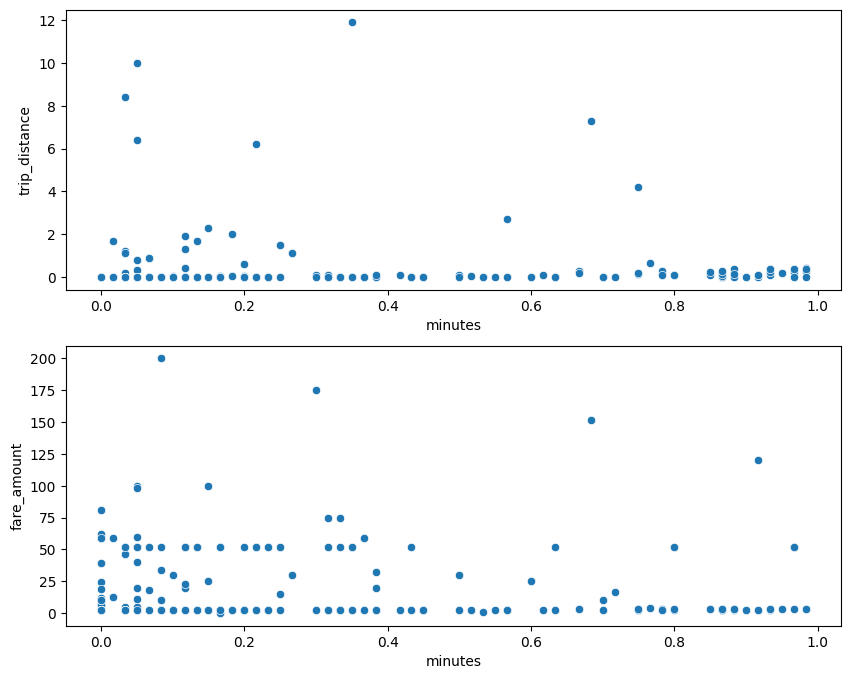

In [41]:
# 이동시간이 1분미만인 데이터 시각화
one_min_df = taxi_df[taxi_df['minutes'] < 1]  # 이동시간이 1분 미만인 데이터만 추출

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.scatterplot(x = one_min_df['minutes'], y = one_min_df['trip_distance'], ax = axes[0])
sns.scatterplot(x = one_min_df['minutes'], y = one_min_df['fare_amount'], ax = axes[1])
plt.show()

In [46]:
# 이동시간이 1분미만인 데이터에서 이동시간과 다른 변수와의 상관계수
# 전체 데이터에서 이동시간의 다른 수치형 변수간의 상관관계
one_min_df.corr(numeric_only=True)['minutes']

,minutes
passenger_count,0.021085
trip_distance,-0.014627
fare_amount,-0.107052
tip_amount,-0.084378
tolls_amount,0.093714
minutes,1.000000


- 이동거리와 이동시간을 시각화한 그래프를 살펴보면 이동시간이 1분미만인데도 10마일을 넘게 간 데이터들도 보인다.
- 이용요금과 이동시간을 시각화한 그래프에서 역시 이동시간이 1분미만인데도 요금이 200달러까지 부과된 경우도 볼 수 있다.
- 두 시각화 그래프에서 0에 가까이 위치한 데이터는 이용한지 얼마되지 않아 취소한 고객으로 추측된다.
- 추가적으로 이용시간 1분미만의 데이터들은 이동거리와 이용요금과 상관관계가 떨어져 전체 데이터와 다른 경향을 보임을 알 수 있다.


결국 위의 데이터들은 택시를 이용했다고 볼 수 없으므로 삭제해준다.

In [47]:
# minute < 1 인 데이터 삭제
print(f'minutes <  1 인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['minutes'] >=  1]
print(f'minutes < 1 인 데이터 삭제 후: {taxi_df.shape}')

minutes <  1 인 데이터 삭제 전: (22643, 11)
minutes < 1 인 데이터 삭제 후: (22439, 11)


### 이동시간이 과도하게 긴 데이터 - 250분 이상
---
위에 scatterplot을 참고하여 이동시간이 250분을 넘는 데이터를 이상치로 간주하고, 250분 미만이 데이터와 250분 이상의 데이터를 나누어 이동거리와 이용요금에 대해 산점도를 그려 비교해본다.


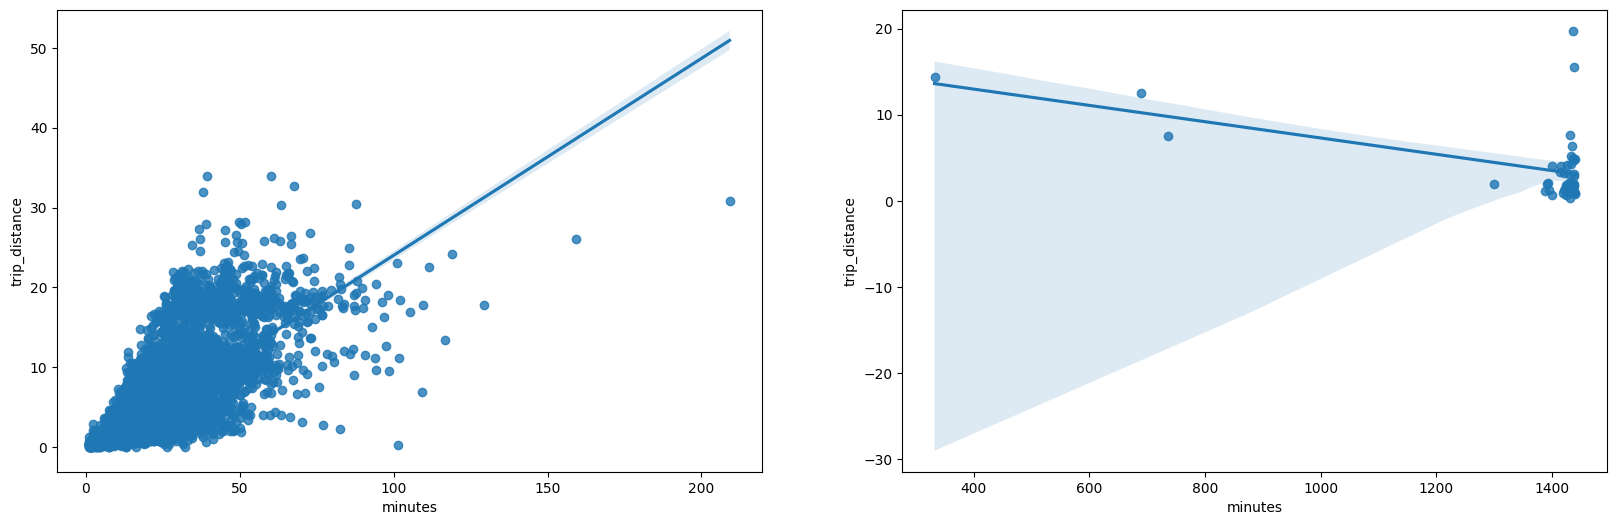

In [77]:
# minutes 이상치 데이터들에 대해 산점도 - trip_distance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.regplot(taxi_df[taxi_df['minutes'] < 250], x = 'minutes', y = 'trip_distance', ax = axes[0])
sns.regplot(taxi_df[taxi_df['minutes'] >= 250], x = 'minutes', y = 'trip_distance', ax = axes[1])
plt.show()

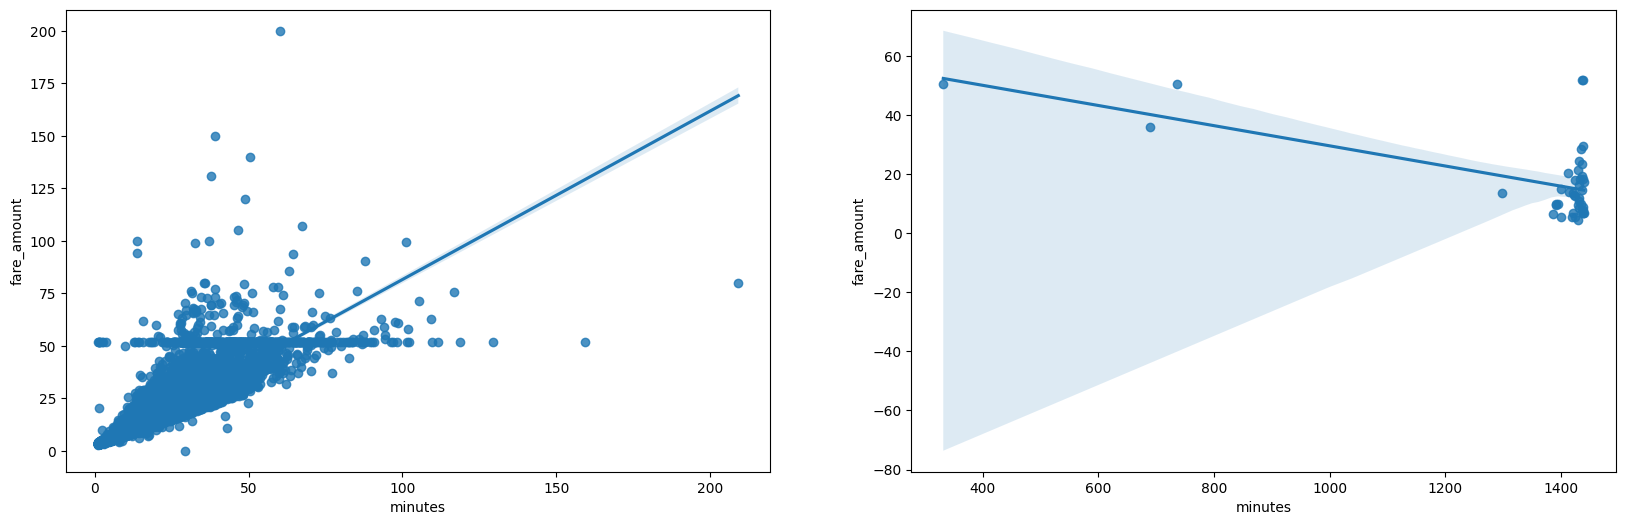

In [78]:
# minutes 이상치 데이터들에 대해 산점도 - trip_distance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.regplot(taxi_df[taxi_df['minutes'] < 250], x = 'minutes', y = 'fare_amount', ax = axes[0])
sns.regplot(taxi_df[taxi_df['minutes'] >= 250], x = 'minutes', y = 'fare_amount', ax = axes[1])
plt.show()

- 첫번째 두 그래프는 x축의 범위와 y축의 범위가 다르다는 걸 고려해도, 250분 이상의 데이터들이 오히려 시간이 길어질수록 이동한 거리가 짧아지는 경향을 보이고 실제로 이동한 거리도 250분 미만의 데이터보다 더 짧음을 알 수 있다.
- 두번째 두 그래프에서도 또한 이동시간이 250분 미만이 데이터는 시간이 늘어남에 따라 이용요금도 늘어나지만 250분 이상 데이터에서는 반대의 경향을 보이며 실제로 이용한 요금이 오히려 비정상적으로 적게 나왔음을 알 수 있다.

따라서 이동시간이 250분 이상의 데이터를 모두 삭제해준다.

In [79]:
# minutes >= 250인 데이터들 삭제
print(f'minutes >= 250 인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['minutes'] < 250]
print(f'minutes >= 250 인 데이터 삭제 후: {taxi_df.shape}')

minutes >= 250 인 데이터 삭제 전: (22439, 11)
minutes >= 250 인 데이터 삭제 후: (22395, 11)


## 이동거리(trip_distance) 살펴보기



In [80]:
# 이동거리(trip_distance) 기술통계량
taxi_df.trip_distance.describe()

,trip_distance
count,22395.000000
mean,2.936094
std,3.658244
min,0.000000
25%,1.000000
50%,1.630000
75%,3.100000
max,33.960000


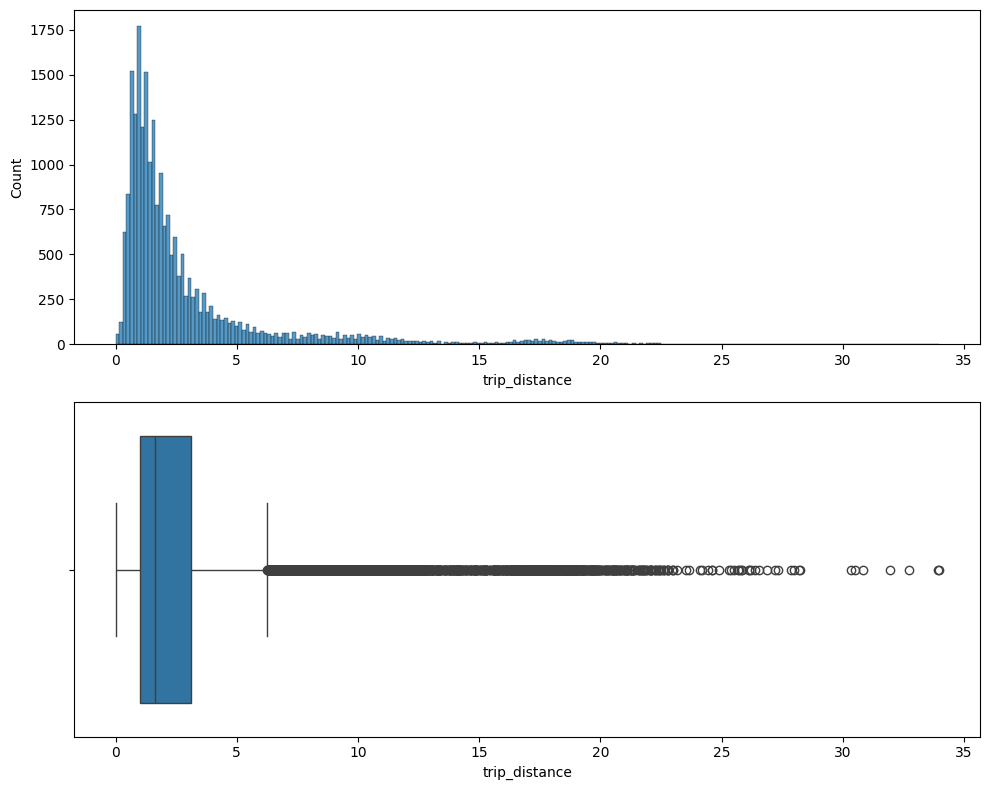

In [81]:
# trip_distance 시각화
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(x = taxi_df['trip_distance'], ax = axes[0])
sns.boxplot(x = taxi_df['trip_distance'], ax = axes[1])
plt.tight_layout()
plt.show()

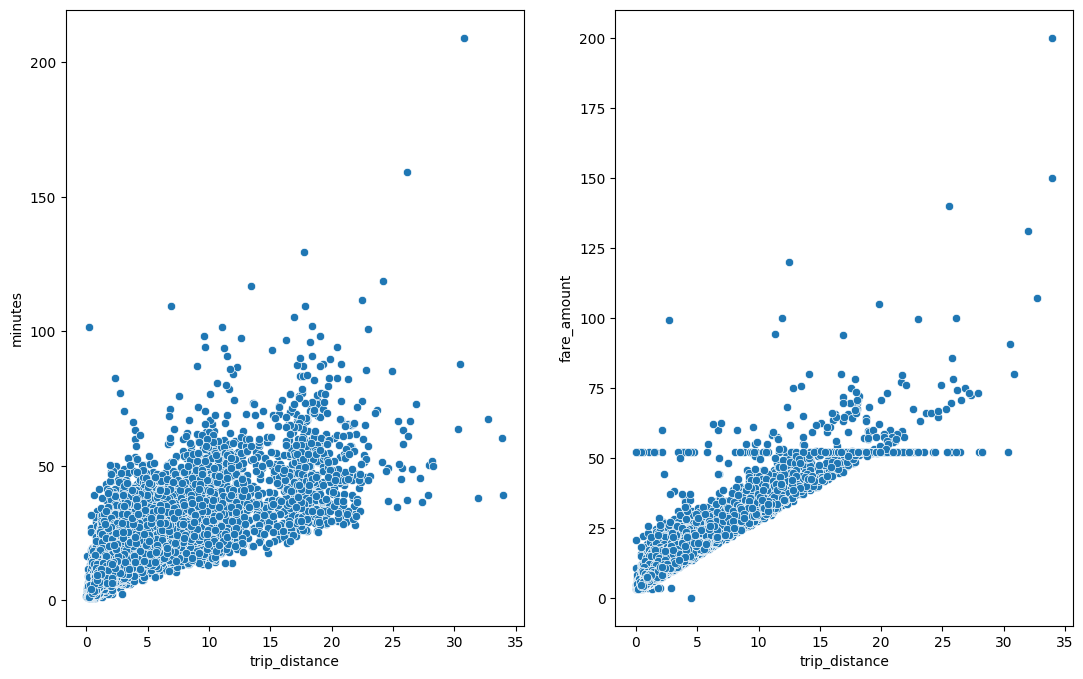

In [95]:
# trip_distance 산점도 - minutes, fare_amount
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 8))
sns.scatterplot(taxi_df, x='trip_distance', y='minutes', ax = axes[0])
sns.scatterplot(taxi_df, x='trip_distance', y='fare_amount', ax = axes[1])
plt.show()

- 이동거리의 데이터가 왼쪽으로 쏠려있어(right skewed) 오른쪽에 위치한 값들을 이상치 볼수 있으나 아래 산점도에서 이동거리가 큰 값들도 경향성에서 크게 벗어나지 않아 이동거리가 과도하게 큰 값에 대해 살펴보지 않기로 한다.

**이상치 확인해보기**
1. 이동거리의 최솟값이 0이다.

### 이동거리가 0인 데이터 확인

In [85]:
# trip_distance = 0인 데이터의 수
zero_distance = taxi_df[taxi_df['trip_distance'] == 0]
zero_distance.shape

(21, 11)

In [86]:
# trip_distance = 0인 데이터
zero_distance

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
3867,Joshua Robinson,2017-06-23 14:43:42,2017-06-23 14:51:15,Debit Card,6,0.0,6.0,0.00,0.0,0 days 00:07:33,7.550000
3975,Catherine Brooks,2017-02-16 14:11:03,2017-02-16 14:12:34,Debit Card,1,0.0,3.0,0.00,0.0,0 days 00:01:31,1.516667
4464,Amanda Dunn,2017-12-14 03:54:31,2017-12-14 03:55:48,Cash,1,0.0,3.0,0.00,0.0,0 days 00:01:17,1.283333
4889,Timothy Garrett,2017-08-01 17:33:00,2017-08-01 17:34:10,Cash,1,0.0,3.0,0.00,0.0,0 days 00:01:10,1.166667
6577,Michael Hendricks,2017-03-31 17:00:35,2017-03-31 17:01:40,Debit Card,1,0.0,3.0,0.00,0.0,0 days 00:01:05,1.083333
8506,Cindy Anderson,2017-06-29 22:20:04,2017-06-29 22:23:44,Credit Card,1,0.0,4.0,0.00,0.0,0 days 00:03:40,3.666667
10925,Chase Clark,2017-11-23 13:45:55,2017-11-23 13:47:18,Debit Card,1,0.0,3.0,0.00,0.0,0 days 00:01:23,1.383333
11252,Michael Wright,2017-05-12 13:34:23,2017-05-12 13:35:38,Cash,1,0.0,3.0,1.10,0.0,0 days 00:01:15,1.250000
14167,Sheila Mack,2017-10-29 01:14:35,2017-10-29 01:18:13,Debit Card,1,0.0,4.8,1.32,0.0,0 days 00:03:38,3.633333
14374,Dr. Kelly Solomon,2017-12-22 13:39:55,2017-12-22 13:44:23,Cash,1,0.0,4.5,0.00,0.0,0 days 00:04:28,4.466667


- 이동거리과 관련있는 이용요금, 이용시간 변수의 값이 특정구간에 있지 않고 퍼져있음을 알 수 있다. 0값을 대체하기 어렵다고 판단되어 삭제해준다.


In [87]:
# trip_distance = 0인 데이터들을 삭제
print(f'trip_distance = 0 인 데이터 삭제 전: {taxi_df.shape}')
taxi_df = taxi_df[taxi_df['trip_distance'] != 0]
print(f'trip_distance = 0 인 데이터 삭제 후: {taxi_df.shape}')

trip_distance = 0 인 데이터 삭제 전: (22395, 11)
trip_distance = 0 인 데이터 삭제 후: (22374, 11)


## 팁(tip_amount) 살펴보기


In [88]:
# tip_amount의 기술 통계량
taxi_df['tip_amount'].describe()

,tip_amount
count,22374.000000
mean,1.822610
std,2.419796
min,0.000000
25%,0.000000
50%,1.360000
75%,2.450000
max,55.500000


<Axes: xlabel='None', ylabel='tip_amount'>

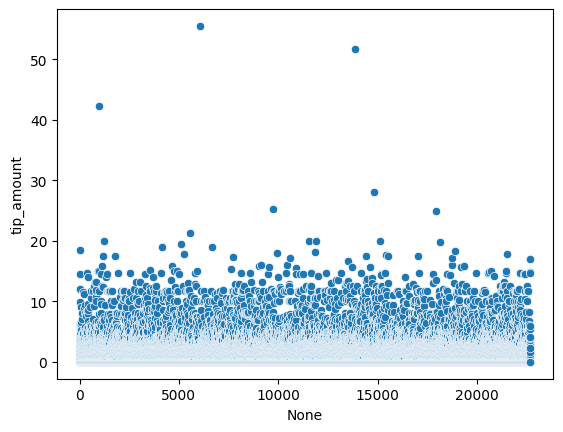

In [97]:
# tip_amount 산점도
sns.scatterplot(taxi_df, x = taxi_df.index, y = 'tip_amount')

**이상치 살펴보기**
1. 팁이 크게 나온 상위 10개값을 추출해본다.

In [100]:
# 팁이 가장 많이 나온 10개의 데이터 추출
taxi_df.sort_values('tip_amount', ascending = False).head(10)

,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
6066,Tina Knight,2017-06-13 12:30:22,2017-06-13 13:37:51,Debit Card,1,32.72,107.00,55.50,16.26,0 days 01:07:29,67.483333
13863,William Yates,2017-05-19 08:20:21,2017-05-19 09:20:30,Credit Card,1,33.92,200.01,51.64,5.76,0 days 01:00:09,60.150000
986,Elaine Horton,2017-08-23 18:23:26,2017-08-23 19:18:29,Cash,1,16.70,52.00,42.29,0.00,0 days 00:55:03,55.050000
14827,John Greer,2017-11-28 20:47:09,2017-11-28 21:22:38,Debit Card,1,20.90,57.50,28.00,2.64,0 days 00:35:29,35.483333
9716,Miss Karen Smith,2017-09-28 11:56:23,2017-09-28 12:21:12,Cash,1,10.02,30.00,25.20,5.76,0 days 00:24:49,24.816667
17936,Jenna Reynolds,2017-05-27 00:14:08,2017-05-27 00:55:25,Cash,2,6.80,29.50,25.00,0.00,0 days 00:41:17,41.283333
5538,Alexander Giles Jr.,2017-03-16 12:14:51,2017-03-16 12:52:36,Cash,1,17.50,69.50,21.30,15.50,0 days 00:37:45,37.750000
11904,Kim Tran,2017-08-28 03:44:41,2017-08-28 04:13:35,Debit Card,2,19.45,52.00,20.00,5.76,0 days 00:28:54,28.900000
11544,Deanna Kelley,2017-06-09 15:25:48,2017-06-09 17:24:40,Debit Card,2,24.20,52.00,20.00,5.76,0 days 01:58:52,118.866667
1254,Jennifer Williams,2017-12-15 16:45:45,2017-12-15 18:27:45,Debit Card,5,18.42,52.00,20.00,5.76,0 days 01:42:00,102.000000


- 하나의 데이터를 제외하고 톨게이트를 이용하며, 어느정도의 거리, 시간, 요금이 정상적으로 입력된 것으로 보아 타당성 있는 데이터라고 판단되어 삭제하지 않는다.
- 참고로, 이용요금이 52인 데이터들이 보이는데, 이는 JFK공항에서 맨해튼 간의 이동에 대해 고정요금(flat rate)가 기본적으로 52$달러가 부과 된다고 한다.

## 톨게이트 비용(tolls_amount) 살펴보기

In [101]:
# 톨게이트 비용 기술통계량
taxi_df['tolls_amount'].describe()

,tolls_amount
count,22374.000000
mean,0.309794
std,1.388190
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,19.100000


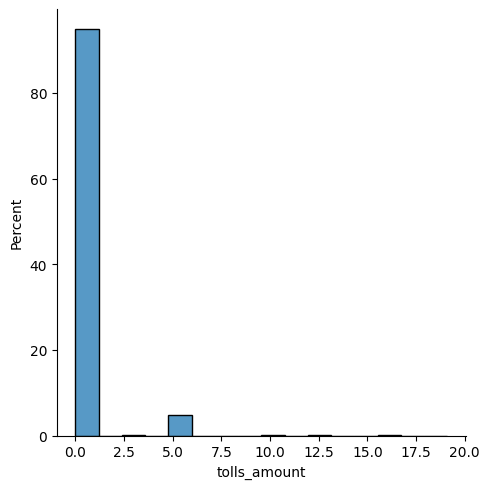

In [104]:
# 톨게이트 비용 시각화
sns.displot(taxi_df['tolls_amount'], stat = 'percent')
plt.show()

- 80%가 넘는 데이터에서 톨게이트 비용이 0이다.
- 미국의 경우 짧은 구간이나 도시 내 유료도로에서 주로 1 ~ 5달러가 부과되고 장거리 톨게이트(주간 고속도로)는 10~30달러 사이로 부과되는 경우가 있다고 한다. 지나치게 큰 값들에 대해서는 데이터를 따로 삭제해주지 않는다.

# 추가사항
---
1. 최종 데이터에 대해 이동시간, 주행거리, 요금 사이의 상관관계 확인
2. 결제 수단에 대해 Credit Card, Debit card모두 Card로 변경해주기

In [111]:
# cleaning한 최종 데이터
taxi_df.info()
taxi_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 22374 entries, 0 to 22700
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   passenger_name         22374 non-null  object         
 1   tpep_pickup_datetime   22374 non-null  datetime64[ns] 
 2   tpep_dropoff_datetime  22374 non-null  datetime64[ns] 
 3   payment_method         22374 non-null  object         
 4   passenger_count        22374 non-null  int64          
 5   trip_distance          22374 non-null  float64        
 6   fare_amount            22374 non-null  float64        
 7   tip_amount             22374 non-null  float64        
 8   tolls_amount           22374 non-null  float64        
 9   duration               22374 non-null  timedelta64[ns]
 10  minutes                22374 non-null  float64        
dtypes: datetime64[ns](2), float64(5), int64(1), object(2), timedelta64[ns](1)
memory usage: 2.0+ MB


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,duration,minutes
0,Pamela Duffy,2017-03-25 08:55:43,2017-03-25 09:09:47,Debit Card,6,3.34,13.0,2.76,0.0,0 days 00:14:04,14.066667
1,Michelle Foster,2017-04-11 14:53:28,2017-04-11 15:19:58,Debit Card,1,1.80,16.0,4.00,0.0,0 days 00:26:30,26.500000
2,Tina Combs,2017-12-15 07:26:56,2017-12-15 07:34:08,Debit Card,1,1.00,6.5,1.45,0.0,0 days 00:07:12,7.200000


<Axes: >

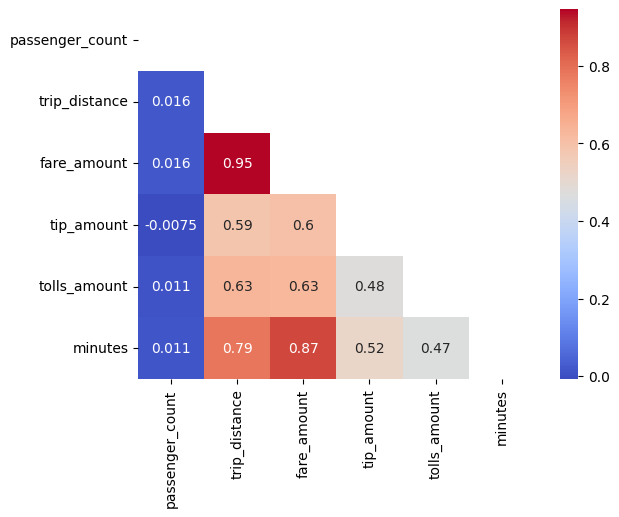

In [114]:
# 최종 데이터에 대해 이동시간, 주행거리, 요금 사이의 상관관계 확인
mask = np.triu(np.ones_like(taxi_df.corr(numeric_only = True)))
sns.heatmap(taxi_df.corr(numeric_only = True), annot = True, cmap = "coolwarm", mask = mask)

In [115]:
# 결제 수단의 범주형
taxi_df['payment_method'].value_counts()

,count
payment_method,
Cash,11028
Debit Card,5706
Credit Card,5640


In [116]:
# 결제 수단에 대해 Credit Card, Debit card모두 Card로 변경해주기
taxi_df = taxi_df.replace({'Credit Card': 'Card' , 'Debit Card':'Card'})
taxi_df['payment_method'].value_counts()

,count
payment_method,
Card,11346
Cash,11028
